# Creating Sim Brains for CVAE Training

In [3]:
pwd

'/mmfs1/data/bergerar/BC-sim/Code'

In [6]:
import ants
import numpy as np
import pandas as pd
import os

In [7]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Sphere Function

In [8]:
def sphere(shape, radius, position):
    """Generate an n-dimensional spherical mask."""
    # assume shape and position have the same length and contain ints
    # the units are pixels / voxels (px for short)
    # radius is a int or float in px
    assert len(position) == len(shape)
    n = len(shape)
    semisizes = (radius,) * len(shape)

    # genereate the grid for the support points
    # centered at the position indicated by position
    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]
    # calculate the distance of all points from `position` center
    # scaled by the radius
    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        # this can be generalized for exponent != 2
        # in which case `(x_i / semisize)`
        # would become `np.abs(x_i / semisize)`
        arr += (x_i / semisize) ** 2

    # the inner part of the sphere will have distance below or equal to 1
    return arr <= 1.0

## Brain Resize

In [9]:
brain_size = (64,64,64)

In [10]:
temp = ants.image_read('../../BC-sim/sub-0010001_Extracted_Brain-Copy1.nii.gz')
temp = ants.resample_image(image=temp,resample_params=brain_size,use_voxels=True,interp_type=1)
temp = temp.iMath_normalize()

In [11]:
temp.max()

1.0

In [12]:
# make sure image was sized correctly
brain_size = temp.shape
print(brain_size)

(64, 64, 64)


## Alteration Function

In [13]:
def do_selective_tx(temp,coords = (32,32,50),sz1=10,sz2=2,do_plot=True):

    sphere_small = temp.new_image_like(sphere(shape=brain_size, radius=sz1, position=coords)*1.0)
    sphere_big = temp.new_image_like(sphere(shape=brain_size, radius=sz2, position=coords)*1.0)

    if do_plot==True:
        temp.plot_ortho(sphere_small*3+sphere_big*7,overlay_cmap='flag',xyz=coords,flat=True,overlay_alpha=.5,title='Deformation Targets')

    mytx = ants.registration(fixed=sphere_big, moving=sphere_small,mask=sphere_big+sphere_small,type_of_transform = 'SyNOnly' ) # learns a vector field from small to big sphere
    #warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0],interpolator='bSpline') # applies the transformation
    warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0])
    #warpedBrain = ants.apply_transforms(fixed=temp, moving=temp,transformlist=mytx['fwdtransforms'][0],interpolator='nearestNeighbor')
    #print(mytx['fwdtransforms'][0])
    #warpedBrain.plot_ortho(flat=True,xyz=coords)

    #mytx['warpedmovout'].plot_ortho(flat=True,xyz=coords)
    if do_plot==True:
        temp.plot_ortho_double(warpedBrain,xyz=coords,title='Before and After',title_dy=.22)
        (warpedBrain-temp).plot_ortho(flat=True,cmap='bwr',xyz=coords,title='Difference Map')
        
    #temp.plot_ortho((temp-warpedBrain)>np.sort((temp-warpedBrain).numpy().flatten())[-250],flat=True,overlay_alpha=.5,overlay_cmap='hot',xyz=coords)
    #temp.plot_ortho(warpedBrain-temp,flat=True,overlay_alpha=.5,overlay_cmap='bwr',xyz=coords)
    
    J = ants.create_jacobian_determinant_image(domain_image=warpedBrain,tx=mytx['fwdtransforms'][0])
    J = J-1
    #J[abs(J.numpy())<.25]=0
    if do_plot==True:
        warpedBrain.plot_ortho(J,flat=True,overlay_alpha=.5,xyz=coords,title='Jacobian Map')
    
    return warpedBrain

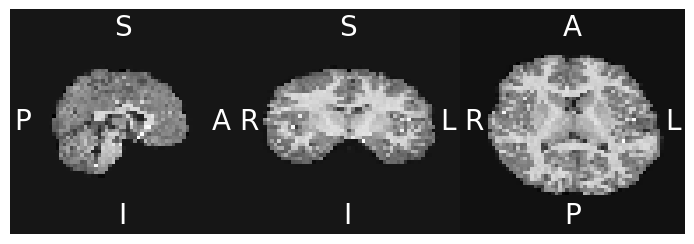

In [14]:
temp.plot_ortho(flat=True,xyz_lines=False)

/data/bergerar/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



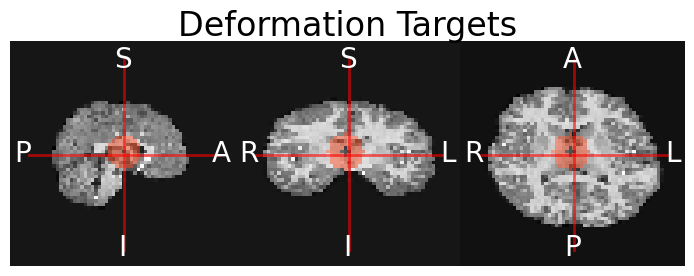

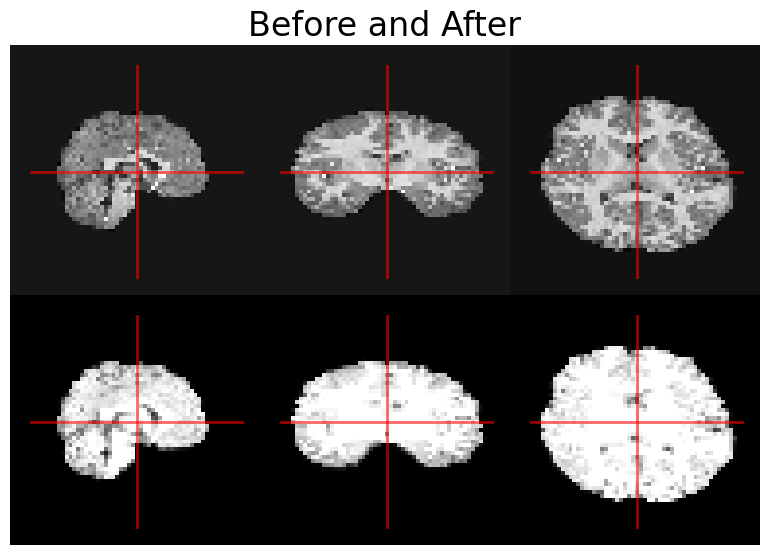

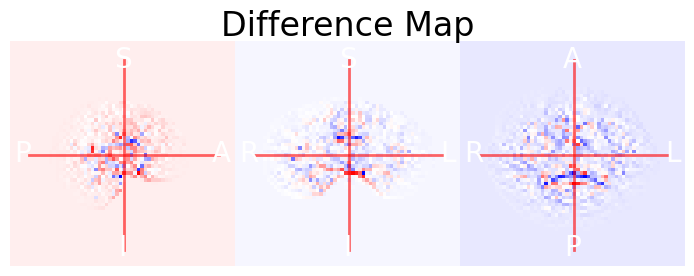

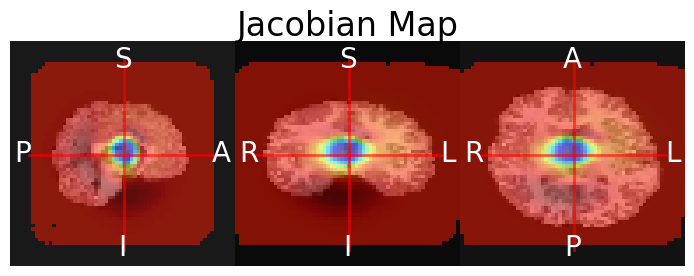

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (64, 64, 64)
	 Spacing    : (2.6811, 4.0476, 4.0476)
	 Origin     : (77.949, 127.7229, -137.1205)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [16]:
do_selective_tx(temp,coords = (32,32,32),sz1=1,sz2=5)

In [1]:
warpedBrain.plot_ortho(flat=True,xyz_lines=False)

NameError: name 'warpedBrain' is not defined

In [15]:
ofn = '../BC-sim/Warped_Brains/TD-sub-0001.nii.gz'
warpedBrain.to_file(ofn) #save it

/data/bergerar/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



NameError: name 'warpedBrain' is not defined

In [ ]:
# ofn = f'../BC-sim/Warped_Brains/{s}_Warped_Brain.nii.gz'
# warpedBrain.to_file(ofn) #save it